In [1]:
import numpy as np
import Derivatives as Div
import Cheb as Ch
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

np.set_printoptions(linewidth=300)

class Parent:
    x = None

class Child1(Parent):
    def __init__(self) -> None:
        self.x = [1, 2]

parent = Parent()
child = Child1()

print(parent.x)
print(child.x)
print(Parent.x)
print(Child1.x)

None
[1, 2]
None
None


Size of x:  30
Shape of D:  (30, 30)


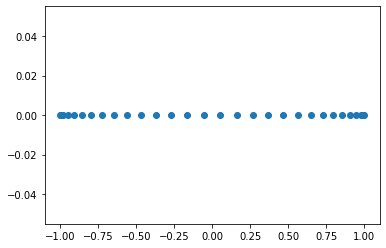

In [2]:
N = 30          
x = Ch.Grid(N, mode='cheb').grid
D = Div.DR(N).matrix

print("Size of x: ", len(x))
print("Shape of D: ", D.shape)

plt.scatter(x, [0 for i in range(N)])
plt.show()

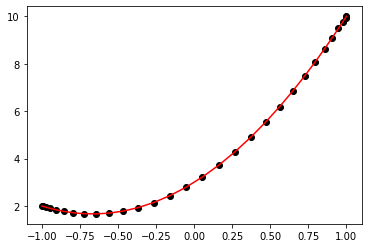

In [3]:
def poly3(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d

def poly3div(x, a, b, c, d):
    return 3*a*x*x + 2*b*x + c


a, b, c, d = 1, 2, 3, 4

ydata = [poly3(i, a, b, c, d) for i in x]   # 3rd degree polynomial values
yRef = [poly3div(i, a, b, c, d) for i in x] # true derivative
yD = D @ ydata                              # spectral derivative


plt.plot(x, yRef, 'r')
plt.scatter(x, yD, c='black')
plt.show()

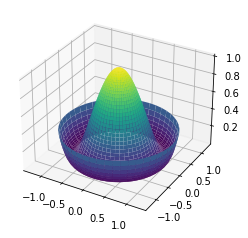

In [4]:
r = np.linspace(0, 1, 20)
t = np.linspace(0, 0.5, 20)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
r = np.linspace(0, 1.25, 50)
p = np.linspace(0, 2*np.pi, 50)
R, P = np.meshgrid(r, p)
Z = ((R**2 - 1)**2)

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap="viridis")
plt.show()


[-5.10702591e-15 -8.88178420e-15 -8.43769499e-15 -9.32587341e-15 -6.52903754e-15 -8.21565038e-15 -3.33066907e-15 -2.88657986e-15 -2.22044605e-16  1.77635684e-15  5.10702591e-15  8.88178420e-15  7.77156117e-15  9.99200722e-15  9.24696423e-15  5.77315973e-15  4.44089210e-15  2.22044605e-16
  1.99840144e-15 -3.55271368e-15  0.00000000e+00 -8.21565038e-15 -1.28785871e-14 -3.66373598e-15 -1.16225049e-14 -4.66293670e-15 -6.21724894e-15 -2.22044605e-15 -4.44089210e-16  1.77635684e-15  5.32907052e-15  9.32587341e-15  9.10382880e-15  9.65894031e-15  8.17580301e-15  7.54951657e-15
  4.66293670e-15  3.33066907e-15 -1.33226763e-15  0.00000000e+00]


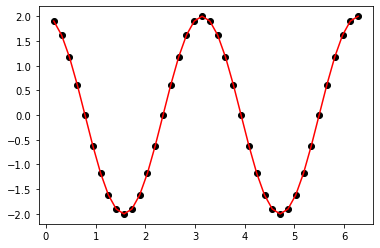

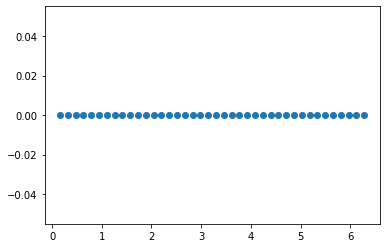

In [22]:
def sin(x, a, b, c, d):
    return a * np.sin(b*x + c)

def sinDiv(x, a, b, c, d):
    return a*b * np.cos(b*x + c)

N = 40
x = Ch.Grid(N, mode='uni').grid
D = Div.DTheta(N).matrix
# x = Ch.Grid(N, mode='cheb').grid
# D = Div.DR(N).matrix

a, b, c, d = 1, 2, 0, 4

ydata = [sin(i, a, b, c, d) for i in x]   # 3rd degree polynomial values
yRef = [sinDiv(i, a, b, c, d) for i in x] # true derivative
yD = D.dot(ydata)                            # spectral derivative

print(yD - yRef)

plt.plot(x, yRef, 'r')
plt.scatter(x, yD, c='black')
plt.show()

plt.scatter(x, [0 for i in range(N)])
plt.show()

In [23]:
# use trick with mirroring radial grid - requires modification to differentiation matrix
# N = 6
NR, NTheta = 8, 8
r = Ch.Grid(NR, mode="cheb").grid[:NR//2]
t = Ch.Grid(NTheta, mode="uni").grid * np.pi
print(t)
D = Div.DR2(NR).matrix
E = Div.DR(NR).matrix
T = Div.DR2(NTheta).matrix
# T = Div.DTheta(NTheta).matrix @ Div.DTheta(NTheta).matrix
R = np.diag(1/r)

d1, d2 = D[:NR//2, :NR//2], D[:NR//2, NR//2:]
e1, e2 = E[:NR//2, :NR//2], E[:NR//2, NR//2:]


diagId = np.identity(NTheta)
antiDiagId = np.kron(np.array([[0, 1], [1, 0]]), np.identity(NTheta//2))
# print(antiDiagId)

# np.kron(d1,diagId) + np.kron(d2, antiDiagId)
operator = np.kron(d1 + R @ e1, diagId) + np.kron(d2 + R @ e2, antiDiagId) + np.kron(R @ R, T)

#shape check
print(operator.shape)
print(np.kron(r, t).shape)

source = np.kron(-1*r*r, np.sin(t/2)**4) + np.kron(np.ones(len(r)), np.sin(6*t) * np.cos(t/2)**2)
sol = np.linalg.solve(operator, source)

print(operator)
print(source)
print(sol)
print("Operator Rank: ", np.linalg.matrix_rank(source))

[ 2.4674011  4.9348022  7.4022033  9.8696044 12.3370055 14.8044066 17.2718077 19.7392088]
(32, 32)
(32,)
[[ 3.36500000e+02 -2.58592028e+02  1.47077338e+02 ... -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
 [ 7.78026842e+01  6.32922239e+01  4.32236013e+01 ... -1.65000000e+01  0.00000000e+00 -0.00000000e+00]
 [-5.69962564e+00  2.22998595e+01  1.47648202e+02 ...  0.00000000e+00 -1.65000000e+01  0.00000000e+00]
 ...
 [ 0.00000000e+00  5.26047542e-01  0.00000000e+00 ... -6.01147855e+02  4.50360590e+02 -1.15107755e+02]
 [ 0.00000000e+00  0.00000000e+00  5.26047542e-01 ...  8.72929560e+02 -2.30477329e+03  1.57127728e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.97032529e+03 -5.22243910e+03  3.21284062e+03]]
[-0.70724633 -0.74520239  0.22066908 -0.88290247 -0.96844811 -0.51047813 -0.23278331 -0.69483783 -0.55792635 -0.71661165  0.23560984 -0.71252165 -0.96841583 -0.38714383 -0.1850629  -0.68838371 -0.2224074  -0.65236885  0.26918142 -0.32967942 -0.9683433  -0.11001416 -0.077

Lattice size:  60
Size after boundary conditions:  3364


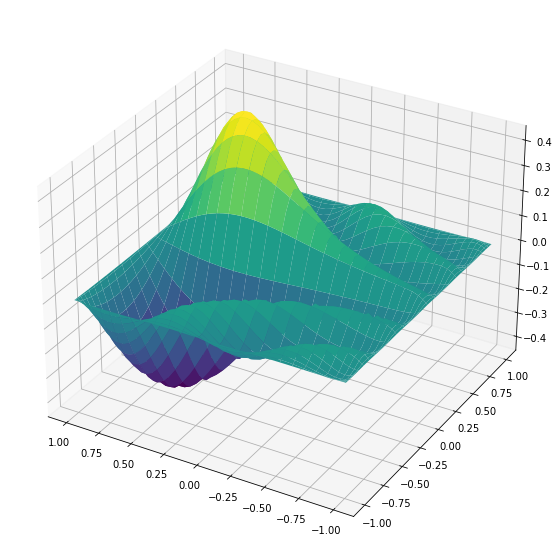

In [7]:
# 2D Poisson and Helmholtz solutions

N = 60
dim = N-2
k = 9
x, y = Ch.Grid(N).grid[1:-1], Ch.Grid(N).grid[1:-1]
D = Div.DR2(N).matrix[1:-1, 1:-1]

# Helmholtz
# L = np.kron(np.identity(dim), D) + np.kron(D, np.identity(dim)) + k*k * np.identity(dim**2)
# source = np.exp(np.kron(np.ones(dim), -10*(y-1)**2) + np.kron(-10*(x-0.5)**2, np.ones(dim)))

# Poisson equation
L = np.kron(np.identity(dim), D) + np.kron(D, np.identity(dim))
source = 10*np.sin(np.kron(8*x, y-1))

sol = np.linalg.solve(L, source).reshape((dim, dim))
print("Lattice size: ", N)
print("Size after boundary conditions: ", dim*dim)
# print("L rank: ", np.linalg.matrix_rank(L))


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh
X, Y = np.meshgrid(x, y)

# Plot the surface.
ax.plot_surface(X, Y, sol, cmap="viridis")
fig.set_size_inches(10, 10)
ax.invert_xaxis()
plt.show()
